In [1]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as PathEffects
import matplotlib.pylab as pylab
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import time
import seaborn as sns
from keras import utils, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [2]:
miner_limit = 10000
non_miner_limit = 10000

In [3]:
# SQL query adapted from https://gist.github.com/allenday/16cf63fb6b3ed59b78903b2d414fe75b
sql = '''
WITH 
output_ages AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_ages_address,
    MIN(block_timestamp_month) AS output_month_min,
    MAX(block_timestamp_month) AS output_month_max
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  GROUP BY output_ages_address
)
,input_ages AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_ages_address,
    MIN(block_timestamp_month) AS input_month_min,
    MAX(block_timestamp_month) AS input_month_max
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
  GROUP BY input_ages_address
)
,output_monthly_stats AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_monthly_stats_address, 
    COUNT(DISTINCT block_timestamp_month) AS output_active_months,
    COUNT(outputs) AS total_tx_output_count,
    SUM(value) AS total_tx_output_value,
    AVG(value) AS mean_tx_output_value,
    STDDEV(value) AS stddev_tx_output_value,
    COUNT(DISTINCT(`hash`)) AS total_output_tx,
    SUM(value)/COUNT(block_timestamp_month) AS mean_monthly_output_value,
    COUNT(outputs.addresses)/COUNT(block_timestamp_month) AS mean_monthly_output_count
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  GROUP BY output_monthly_stats_address
)
,input_monthly_stats AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_monthly_stats_address, 
    COUNT(DISTINCT block_timestamp_month) AS input_active_months,
    COUNT(inputs) AS total_tx_input_count,
    SUM(value) AS total_tx_input_value,
    AVG(value) AS mean_tx_input_value,
    STDDEV(value) AS stddev_tx_input_value,
    COUNT(DISTINCT(`hash`)) AS total_input_tx,
    SUM(value)/COUNT(block_timestamp_month) AS mean_monthly_input_value,
    COUNT(inputs.addresses)/COUNT(block_timestamp_month) AS mean_monthly_input_count
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
  GROUP BY input_monthly_stats_address
)
,output_idle_times AS (
  SELECT
    address AS idle_time_address,
    AVG(idle_time) AS mean_output_idle_time,
    STDDEV(idle_time) AS stddev_output_idle_time
  FROM
  (
    SELECT 
      event.address,
      IF(prev_block_time IS NULL, NULL, UNIX_SECONDS(block_time) - UNIX_SECONDS(prev_block_time)) AS idle_time
    FROM (
      SELECT
        ARRAY_TO_STRING(outputs.addresses,',') AS address, 
        block_timestamp AS block_time,
        LAG(block_timestamp) OVER (PARTITION BY ARRAY_TO_STRING(outputs.addresses,',') ORDER BY block_timestamp) AS prev_block_time
      FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
    ) AS event
    WHERE block_time != prev_block_time
  )
  GROUP BY address
)
,input_idle_times AS (
  SELECT
    address AS idle_time_address,
    AVG(idle_time) AS mean_input_idle_time,
    STDDEV(idle_time) AS stddev_input_idle_time
  FROM
  (
    SELECT 
      event.address,
      IF(prev_block_time IS NULL, NULL, UNIX_SECONDS(block_time) - UNIX_SECONDS(prev_block_time)) AS idle_time
    FROM (
      SELECT
        ARRAY_TO_STRING(inputs.addresses,',') AS address, 
        block_timestamp AS block_time,
        LAG(block_timestamp) OVER (PARTITION BY ARRAY_TO_STRING(inputs.addresses,',') ORDER BY block_timestamp) AS prev_block_time
      FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
    ) AS event
    WHERE block_time != prev_block_time
  )
  GROUP BY address
)
--,miners AS (
--)

(SELECT
  TRUE AS is_miner,
  output_ages_address AS address,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_month_min,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) AS output_month_max,
  UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_month_min,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS input_month_max,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_active_time,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_active_time,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS io_max_lag,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS io_min_lag,
  output_monthly_stats.output_active_months,
  output_monthly_stats.total_tx_output_count,
  output_monthly_stats.total_tx_output_value,
  output_monthly_stats.mean_tx_output_value,
  output_monthly_stats.stddev_tx_output_value,
  output_monthly_stats.total_output_tx,
  output_monthly_stats.mean_monthly_output_value,
  output_monthly_stats.mean_monthly_output_count,
  input_monthly_stats.input_active_months,
  input_monthly_stats.total_tx_input_count,
  input_monthly_stats.total_tx_input_value,
  input_monthly_stats.mean_tx_input_value,
  input_monthly_stats.stddev_tx_input_value,
  input_monthly_stats.total_input_tx,
  input_monthly_stats.mean_monthly_input_value,
  input_monthly_stats.mean_monthly_input_count,
  output_idle_times.mean_output_idle_time,
  output_idle_times.stddev_output_idle_time,
  input_idle_times.mean_input_idle_time,
  input_idle_times.stddev_input_idle_time
FROM
  output_ages, output_monthly_stats, output_idle_times,
  input_ages,  input_monthly_stats, input_idle_times
WHERE TRUE
  AND output_ages.output_ages_address = output_monthly_stats.output_monthly_stats_address
  AND output_ages.output_ages_address = output_idle_times.idle_time_address
  AND output_ages.output_ages_address = input_monthly_stats.input_monthly_stats_address
  AND output_ages.output_ages_address = input_ages.input_ages_address
  AND output_ages.output_ages_address = input_idle_times.idle_time_address
  AND output_ages.output_ages_address IN
(
  SELECT 
    ARRAY_TO_STRING(outputs.addresses,',') AS miner
  FROM 
  `bigquery-public-data.crypto_bitcoin.blocks` AS blocks,
  `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  WHERE blocks.hash = transactions.block_hash 
    AND is_coinbase IS TRUE
    AND ( FALSE
      --
      -- miner signatures from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
      --
      OR coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' --AntPool
      OR coinbase_param LIKE '%2f42434d6f6e737465722f%' --BCMonster
      --BitcoinAffiliateNetwork
      OR coinbase_param LIKE '%4269744d696e746572%' --BitMinter
      --BTC.com
      --BTCC Pool
      --BTCDig
      OR coinbase_param LIKE '%2f7374726174756d2f%' --Btcmp
      --btcZPool.com
      --BW Mining
      OR coinbase_param LIKE '%456c6967697573%' --Eligius
      --F2Pool
      --GHash.IO
      --Give Me COINS
      --Golden Nonce Pool
      OR coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' --Bravo Mining
      OR coinbase_param LIKE '%4b616e6f%' --KanoPool
      --kmdPool.org
      OR coinbase_param LIKE '%2f6d6d706f6f6c%' --Merge Mining Pool
      --MergeMining
      --Multipool
      --P2Pool
      OR coinbase_param LIKE '%2f736c7573682f%' --Slush Pool
      --ZenPool.org
    )
  GROUP BY miner
  HAVING COUNT(1) >= 20 
)
LIMIT {})
UNION ALL
(SELECT
  FALSE AS is_miner,
  output_ages_address AS address,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_month_min,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) AS output_month_max,
  UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_month_min,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS input_month_max,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_active_time,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_active_time,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS io_max_lag,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS io_min_lag,
  output_monthly_stats.output_active_months,
  output_monthly_stats.total_tx_output_count,
  output_monthly_stats.total_tx_output_value,
  output_monthly_stats.mean_tx_output_value,
  output_monthly_stats.stddev_tx_output_value,
  output_monthly_stats.total_output_tx,
  output_monthly_stats.mean_monthly_output_value,
  output_monthly_stats.mean_monthly_output_count,
  input_monthly_stats.input_active_months,
  input_monthly_stats.total_tx_input_count,
  input_monthly_stats.total_tx_input_value,
  input_monthly_stats.mean_tx_input_value,
  input_monthly_stats.stddev_tx_input_value,
  input_monthly_stats.total_input_tx,
  input_monthly_stats.mean_monthly_input_value,
  input_monthly_stats.mean_monthly_input_count,
  output_idle_times.mean_output_idle_time,
  output_idle_times.stddev_output_idle_time,
  input_idle_times.mean_input_idle_time,
  input_idle_times.stddev_input_idle_time
FROM
  output_ages, output_monthly_stats, output_idle_times,
  input_ages,  input_monthly_stats, input_idle_times
WHERE TRUE
  AND output_ages.output_ages_address = output_monthly_stats.output_monthly_stats_address
  AND output_ages.output_ages_address = output_idle_times.idle_time_address
  AND output_ages.output_ages_address = input_monthly_stats.input_monthly_stats_address
  AND output_ages.output_ages_address = input_ages.input_ages_address
  AND output_ages.output_ages_address = input_idle_times.idle_time_address
  AND output_ages.output_ages_address NOT IN
(
  SELECT 
    ARRAY_TO_STRING(outputs.addresses,',') AS miner
  FROM 
  `bigquery-public-data.crypto_bitcoin.blocks` AS blocks,
  `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  WHERE blocks.hash = transactions.block_hash 
    AND is_coinbase IS TRUE
    AND ( FALSE
      --
      -- miner signatures from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
      --
      OR coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' --AntPool
      OR coinbase_param LIKE '%2f42434d6f6e737465722f%' --BCMonster
      --BitcoinAffiliateNetwork
      OR coinbase_param LIKE '%4269744d696e746572%' --BitMinter
      --BTC.com
      --BTCC Pool
      --BTCDig
      OR coinbase_param LIKE '%2f7374726174756d2f%' --Btcmp
      --btcZPool.com
      --BW Mining
      OR coinbase_param LIKE '%456c6967697573%' --Eligius
      --F2Pool
      --GHash.IO
      --Give Me COINS
      --Golden Nonce Pool
      OR coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' --Bravo Mining
      OR coinbase_param LIKE '%4b616e6f%' --KanoPool
      --kmdPool.org
      OR coinbase_param LIKE '%2f6d6d706f6f6c%' --Merge Mining Pool
      --MergeMining
      --Multipool
      --P2Pool
      OR coinbase_param LIKE '%2f736c7573682f%' --Slush Pool
      --ZenPool.org
    )
  GROUP BY miner
  HAVING COUNT(1) >= 20 
)
LIMIT {})
'''.format(miner_limit, non_miner_limit)

In [4]:

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\srish\Documents\NEU\Parallell ML and AI\Untitled Folder\json\My First Project-dd9334d0c0a8.json"
client = bigquery.Client()


In [5]:
time_start = time.time()
df = client.query(sql).to_dataframe()
print('Time elapsed: {} seconds' .format(time.time() - time_start))

Time elapsed: 217.58639121055603 seconds


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 30 columns):
is_miner                     20000 non-null bool
address                      20000 non-null object
output_month_min             20000 non-null int64
output_month_max             20000 non-null int64
input_month_min              20000 non-null int64
input_month_max              20000 non-null int64
output_active_time           20000 non-null int64
input_active_time            20000 non-null int64
io_max_lag                   20000 non-null int64
io_min_lag                   20000 non-null int64
output_active_months         20000 non-null int64
total_tx_output_count        20000 non-null int64
total_tx_output_value        20000 non-null object
mean_tx_output_value         20000 non-null object
stddev_tx_output_value       20000 non-null float64
total_output_tx              20000 non-null int64
mean_monthly_output_value    20000 non-null object
mean_monthly_output_count    20000 n

In [7]:
# Dropping the columns with null values
df.drop(labels = ['stddev_output_idle_time','stddev_input_idle_time'], axis = 1, inplace = True)

In [8]:
df.tail(5)

,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
19995,True,1LfpdXUwwjKWo14jip65stCtPx8uuFVD6M,1367366400,1383264000,1372636800,1380585600,15897600,7948800,2678400,-5270400,...,3,44,767864999,17451477.25,1.604927e+06,3,17451477.25,1.0,3.827791e+05,4.632795e+06
19996,True,16vEux5txgZmAjNnubiLiww73YjGoD1z2m,1406851200,1454284800,1414800000,1512086400,47433600,97286400,-57801600,-7948800,...,6,43,175121718,4072598.093023256,1.140707e+06,9,4072598.093023256,1.0,1.074704e+06,1.234450e+07
19997,True,1Kk7qPuXBrPec6gMVG3Kb5LSdNy1sTxug4,1385856000,1396310400,1396310400,1409529600,10454400,13219200,-13219200,-10454400,...,4,45,207314621,4606991.577777778,8.493911e+05,6,4606991.577777778,1.0,2.290950e+05,2.263600e+06
19998,True,1Nkt79pFX1UrRyfcizy4bu76mdzaAYaMmN,1383264000,1388534400,1383264000,1388534400,5270400,5270400,0,0,...,3,45,72574466,1612765.911111111,9.891429e+05,26,1612765.911111111,1.0,1.224688e+05,2.178087e+05
19999,True,1GUjSF4ZEQmZAL6du6XntXdqQ9uR1mYkdi,1393632000,1483228800,1393632000,1425168000,89596800,31536000,58060800,0,...,9,44,280232160,6368912.727272727,7.679995e+06,33,6368912.727272727,1.0,1.997034e+06,9.776704e+05


In [9]:
df.head(5)

,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
0,False,3KsBM6BNwqSibdBbHR6cJpXSjiMB14jtUU,1514764800,1535760000,1514764800,1535760000,20995200,20995200,0,0,...,9,19,29979096,1577847.157894737,5.178192e+05,19,1577847.157894737,1.0,1.158474e+06,1.106894e+06
1,False,32ok8QhsfsnzpYRAFbh4b12683Y77tyZiY,1464739200,1472688000,1467331200,1530403200,7948800,63072000,-57715200,-2592000,...,10,20,8687876,434393.8,2.685206e+05,20,434393.8,1.0,5.197101e+05,3.234552e+06
2,False,1Ht1MAt6t6U9NBdXE4eM2wcvTsSpNtsnM5,1477958400,1498867200,1477958400,1498867200,20908800,20908800,0,0,...,8,19,16038019,844106.263157895,5.104314e+05,19,844106.263157895,1.0,1.078961e+06,1.115924e+06
3,False,1GYJEU4mX33Fa9Wuw4Yc8ZZWFQ1wFVXr9s,1498867200,1506816000,1498867200,1506816000,7948800,7948800,0,0,...,3,11,1788306499,162573318.090909091,1.160758e+08,11,162573318.090909091,1.0,5.392838e+05,7.549844e+05
4,False,17ky7N2BPVm3iVT3cyebjzkMMeLSUgS2QJ,1541030400,1569888000,1543622400,1569888000,28857600,26265600,0,-2592000,...,11,173,276774337,1599851.658959538,2.400947e+06,146,1599851.658959538,1.0,1.941717e+05,1.914987e+05


In [10]:
df.shape

(20000, 28)

In [11]:
# Dropping the non-numeric features
features = df.drop(labels = ['is_miner', 'address'], axis = 1)
target = df['is_miner'].values
indices = range(len(features))

In [12]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale = 1.5, rc = {"lines.linewidth": 2.5})

In [13]:
def bitcoin_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize = (8, 8))
    ax = plt.subplot(aspect = 'equal')
    sc = ax.scatter(x[:,0], x[:,1], lw = 0, s = 40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    plt.title('t-SNE to visualize features')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis = 0)
        txt = ax.text(xtext, ytext, str(i), fontsize = 24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth = 5, foreground = "w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts


In [14]:
time_start = time.time()
RS = 123
bitcoin_tsne = TSNE(random_state = RS).fit_transform(features)
print('Time elapsed: {} seconds' .format(time.time() - time_start))

Time elapsed: 245.62672805786133 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(-4.7729273, -30.686726, '0'), Text(4.4394693, 26.678068, '1')])

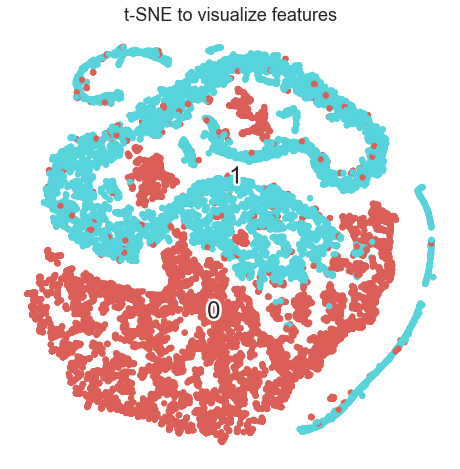

In [16]:
bitcoin_scatter(bitcoin_tsne, target)

In [29]:
plt.savefig('tSNE1.jpg')

<Figure size 432x288 with 0 Axes>

In [30]:
# Splitting the training and testing dataset
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(features, target, indices,  test_size = 0.2)

In [31]:
x_train.head()

,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,output_active_months,total_tx_output_count,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
9020,1561939200,1564617600,1564617600,1564617600,2678400,0,0,-2678400,2,2,...,1,2,24643959,12321979.5,2.307446e+06,2,12321979.5,1.0,433917.000000,4.397100e+05
3734,1391212800,1404172800,1393632000,1409529600,12960000,15897600,-5356800,-2419200,6,48,...,6,48,339151833,7065663.1875,3.832933e+06,27,7065663.1875,1.0,280803.659574,6.544084e+05
2551,1414800000,1483228800,1427846400,1459468800,68428800,31622400,23760000,-13046400,23,186,...,3,178,2215747225,12448018.117977528,2.141321e+07,8,12448018.117977528,1.0,369801.021622,4.557543e+06
1482,1388534400,1438387200,1388534400,1504224000,49852800,115689600,-65836800,0,12,119,...,3,13,52645573,4049659.461538462,2.921068e+06,6,4049659.461538462,1.0,407571.135593,2.293463e+07
8518,1377993600,1438387200,1377993600,1446336000,60393600,68342400,-7948800,0,9,89,...,7,89,5667191255,63676306.235955056,1.668701e+08,17,63676306.235955056,1.0,717049.395349,4.336956e+06


In [32]:
x_train.shape

(16000, 26)

In [33]:
y_train

array([False,  True,  True, ...,  True,  True, False])

In [34]:
# Feature Scaling
sc_x = StandardScaler()
x_train_ann = sc_x.fit_transform(x_train)
x_test_ann = sc_x.transform(x_test)

In [35]:
num_classes = 2

# Hyperparameters
learn_rate = 0.001
batch_size = 500
epochs = 270

In [36]:
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
y_train_ann = labelencoder_y.fit_transform(y_train)

# Converting to binary class matrix
y_train_ann = utils.to_categorical(y_train_ann, num_classes)

In [37]:
y_train_ann.shape

(16000, 2)

In [38]:
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
y_test_ann = labelencoder_y.fit_transform(y_test)

# Converting to binary class matrix
y_test_ann = utils.to_categorical(y_test_ann, num_classes)

In [39]:
y_test_ann.shape

(4000, 2)

In [40]:
seed = 1
np.random.seed(seed)

# Creating model
ann = Sequential()
ann.add(Dense(26, activation = 'tanh', kernel_initializer = 'glorot_uniform'))
ann.add(Dense(11, activation = 'tanh'))
ann.add(Dropout(0.5))
ann.add(Dense(6, activation = 'tanh'))
ann.add(Dense(num_classes, activation = 'softmax'))

In [41]:
rmsprop = optimizers.RMSprop(learn_rate)
ann.compile(loss = 'binary_crossentropy', optimizer = rmsprop, metrics = ['binary_accuracy']) # Compiling the model

In [42]:
# Model fitting
ann.fit(np.array(x_train_ann), y_train_ann, batch_size = batch_size, epochs = epochs, validation_data = (x_test_ann, y_test_ann))

Train on 16000 samples, validate on 4000 samples
Epoch 1/270
16000/16000 [==============================] - 1s 48us/step - loss: 0.3892 - binary_accuracy: 0.8646 - val_loss: 0.2392 - val_binary_accuracy: 0.9350
Epoch 2/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.2353 - binary_accuracy: 0.9354 - val_loss: 0.1769 - val_binary_accuracy: 0.9452
Epoch 3/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.1832 - binary_accuracy: 0.9464 - val_loss: 0.1505 - val_binary_accuracy: 0.9492
Epoch 4/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.1584 - binary_accuracy: 0.9508 - val_loss: 0.1354 - val_binary_accuracy: 0.9560
Epoch 5/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.1415 - binary_accuracy: 0.9559 - val_loss: 0.1241 - val_binary_accuracy: 0.9590
Epoch 6/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.1254 - binary_accuracy: 0.9590 - val_loss: 0.1113 - val_binary_a

Epoch 51/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0533 - binary_accuracy: 0.9851 - val_loss: 0.0554 - val_binary_accuracy: 0.9843
Epoch 52/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0536 - binary_accuracy: 0.9844 - val_loss: 0.0567 - val_binary_accuracy: 0.9833
Epoch 53/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0519 - binary_accuracy: 0.9856 - val_loss: 0.0562 - val_binary_accuracy: 0.9852
Epoch 54/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0532 - binary_accuracy: 0.9853 - val_loss: 0.0573 - val_binary_accuracy: 0.9835
Epoch 55/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0531 - binary_accuracy: 0.9852 - val_loss: 0.0549 - val_binary_accuracy: 0.9852
Epoch 56/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0522 - binary_accuracy: 0.9851 - val_loss: 0.0554 - val_binary_accuracy: 0.9845
Epoch 57/270
16000/16000 [==

16000/16000 [==============================] - 0s 7us/step - loss: 0.0451 - binary_accuracy: 0.9872 - val_loss: 0.0561 - val_binary_accuracy: 0.9852
Epoch 102/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0457 - binary_accuracy: 0.9871 - val_loss: 0.0557 - val_binary_accuracy: 0.9850
Epoch 103/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0444 - binary_accuracy: 0.9878 - val_loss: 0.0588 - val_binary_accuracy: 0.9847
Epoch 104/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0454 - binary_accuracy: 0.9868 - val_loss: 0.0557 - val_binary_accuracy: 0.9850
Epoch 105/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0456 - binary_accuracy: 0.9872 - val_loss: 0.0585 - val_binary_accuracy: 0.9843
Epoch 106/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0462 - binary_accuracy: 0.9876 - val_loss: 0.0598 - val_binary_accuracy: 0.9843
Epoch 107/270
16000/16000 [=========

16000/16000 [==============================] - 0s 8us/step - loss: 0.0412 - binary_accuracy: 0.9883 - val_loss: 0.0568 - val_binary_accuracy: 0.9850
Epoch 152/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0429 - binary_accuracy: 0.9877 - val_loss: 0.0551 - val_binary_accuracy: 0.9858
Epoch 153/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0426 - binary_accuracy: 0.9881 - val_loss: 0.0548 - val_binary_accuracy: 0.9855
Epoch 154/270
16000/16000 [==============================] - 0s 7us/step - loss: 0.0407 - binary_accuracy: 0.9887 - val_loss: 0.0610 - val_binary_accuracy: 0.9837
Epoch 155/270
16000/16000 [==============================] - 0s 10us/step - loss: 0.0427 - binary_accuracy: 0.9876 - val_loss: 0.0554 - val_binary_accuracy: 0.9858
Epoch 156/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0411 - binary_accuracy: 0.9885 - val_loss: 0.0537 - val_binary_accuracy: 0.9858
Epoch 157/270
16000/16000 [========

16000/16000 [==============================] - 0s 8us/step - loss: 0.0393 - binary_accuracy: 0.9883 - val_loss: 0.0542 - val_binary_accuracy: 0.9860
Epoch 202/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0403 - binary_accuracy: 0.9889 - val_loss: 0.0534 - val_binary_accuracy: 0.9862
Epoch 203/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0420 - binary_accuracy: 0.9887 - val_loss: 0.0542 - val_binary_accuracy: 0.9858
Epoch 204/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0394 - binary_accuracy: 0.9895 - val_loss: 0.0563 - val_binary_accuracy: 0.9850
Epoch 205/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0392 - binary_accuracy: 0.9891 - val_loss: 0.0545 - val_binary_accuracy: 0.9860
Epoch 206/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0397 - binary_accuracy: 0.9892 - val_loss: 0.0555 - val_binary_accuracy: 0.9858
Epoch 207/270
16000/16000 [=========

16000/16000 [==============================] - 0s 8us/step - loss: 0.0391 - binary_accuracy: 0.9892 - val_loss: 0.0541 - val_binary_accuracy: 0.9855
Epoch 252/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0386 - binary_accuracy: 0.9891 - val_loss: 0.0535 - val_binary_accuracy: 0.9855
Epoch 253/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0387 - binary_accuracy: 0.9893 - val_loss: 0.0527 - val_binary_accuracy: 0.9868
Epoch 254/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0383 - binary_accuracy: 0.9893 - val_loss: 0.0507 - val_binary_accuracy: 0.9862
Epoch 255/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0392 - binary_accuracy: 0.9890 - val_loss: 0.0537 - val_binary_accuracy: 0.9865
Epoch 256/270
16000/16000 [==============================] - 0s 8us/step - loss: 0.0389 - binary_accuracy: 0.9895 - val_loss: 0.0536 - val_binary_accuracy: 0.9858
Epoch 257/270
16000/16000 [=========

In [43]:
ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 26)                702       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                297       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 14        
Total params: 1,085
Trainable params: 1,085
Non-trainable params: 0
_________________________________________________________________


In [44]:
scores = ann.evaluate(x_test_ann, y_test_ann, verbose = 0)
print("Test Accuracy (Artificial Neural Network): {}%" .format(scores[1] * 100))

Test Accuracy (Artificial Neural Network): 98.62499833106995%


In [45]:
scores

[0.05496803922392428, 0.9862499833106995]

In [46]:
y_pred = ann.predict(x_test_ann)

# Compute confusion matrix
matrix = confusion_matrix(y_test_ann.argmax(axis = 1), y_pred.argmax(axis = 1)) # Building the confusion matrix

In [47]:
matrix

array([[1950,   39],
       [  16, 1995]], dtype=int64)

In [48]:
# Training the model
rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced')
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [49]:
# Model predictions
y_pred = rf.predict(x_test)
probs = rf.predict_proba(x_test)[:, 1] # Positive class probabilities

In [50]:
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'x-small',
         'axes.titlesize':'small',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)

Confusion matrix, without normalization
[[1960   29]
 [  10 2001]]


<Figure size 432x288 with 0 Axes>

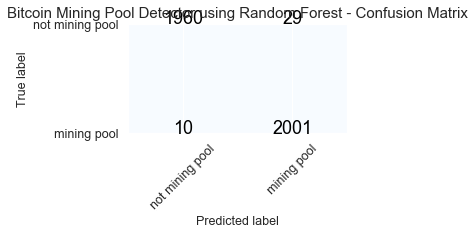

In [51]:
# Confusion matrix code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    dummy = np.array([[0, 0], [0, 0]])
    plt.figure(figsize = (6, 6))
    plt.imshow(dummy, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['not mining pool', 'mining pool']
np.set_printoptions(precision = 2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Bitcoin Mining Pool Detector using Random Forest - Confusion Matrix')

plt.show()

In [52]:
# Calculating Accuracy
acc = (cnf_matrix[0][0] + cnf_matrix[1][1]) / (cnf_matrix[0][0] + cnf_matrix[1][1] + cnf_matrix[0][1] + cnf_matrix[1][0])

In [53]:
print("Test Accuracy (Random Forest Classification): {}%" .format(acc * 100))

Test Accuracy (Random Forest Classification): 99.02499999999999%


In [54]:
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'
         }
pylab.rcParams.update(params)

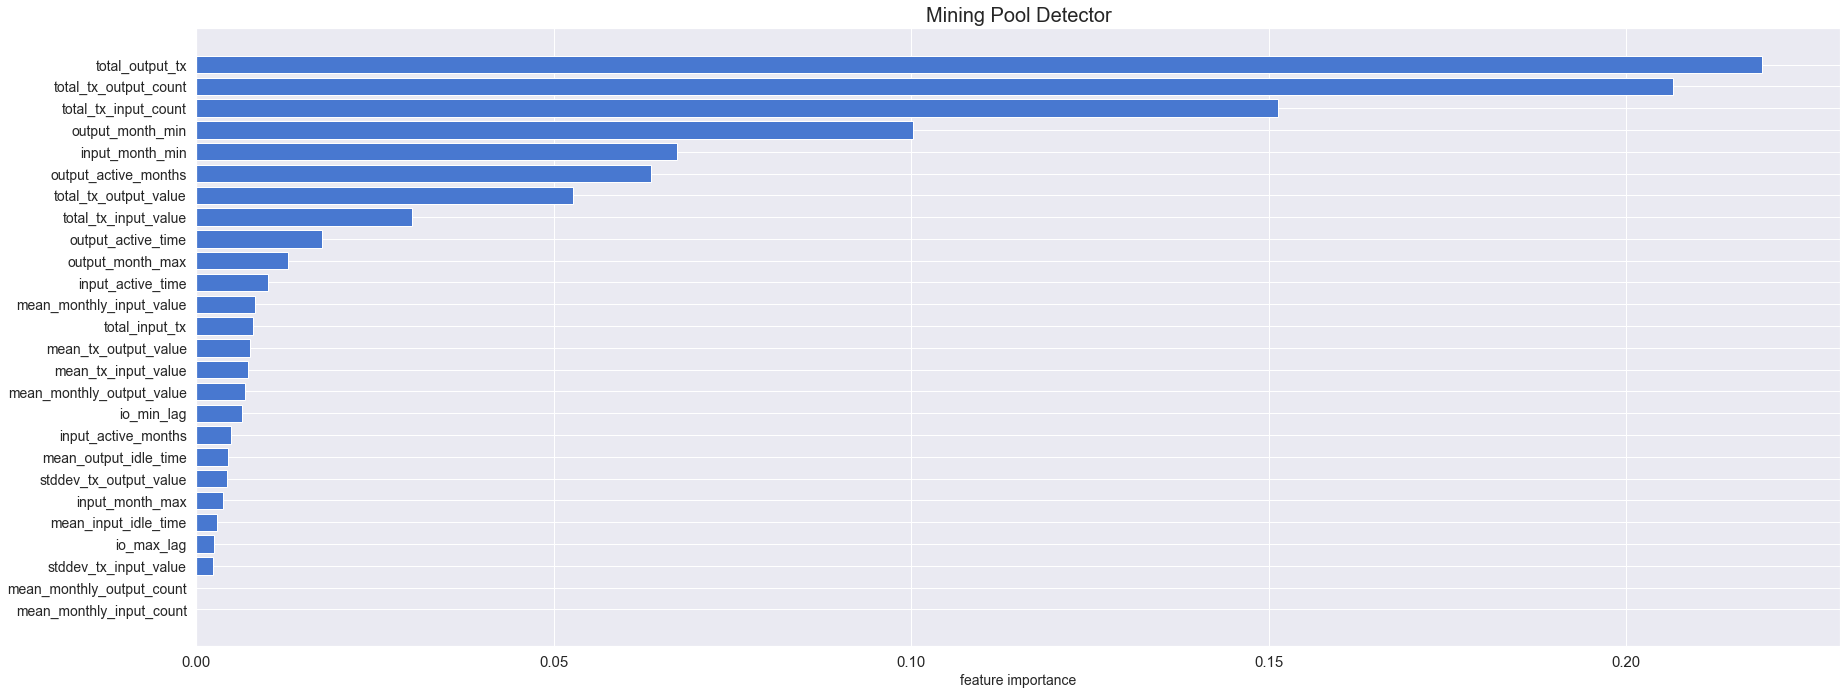

In [55]:
x_pos = np.arange(len(features.columns))
btc_importances = rf.feature_importances_

inds = np.argsort(btc_importances)[::-1]
btc_importances = btc_importances[inds]
cols = features.columns[inds]
bar_width = .8

# How many features to plot?
n_features = 26
x_pos = x_pos[:n_features][::-1]
btc_importances = btc_importances[:n_features]

# Plot
plt.figure(figsize = (26, 10))
plt.barh(x_pos, btc_importances, bar_width, label = 'BTC model')
plt.yticks(x_pos, cols, rotation = 0, fontsize = 14)
plt.xlabel('feature importance', fontsize = 14)
plt.title('Mining Pool Detector', fontsize = 20)
plt.tight_layout()

In [56]:
# Data points where model predicts true, but are labelled as false
false_positives = (y_test == False) & (y_pred == True)

In [57]:
# Subset to test set data only
df_test = df.iloc[indices_test, :]

print('False Positive addresses')

# Subset test set to false positives only
df_test.iloc[false_positives].head(15)

False Positive addresses


,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
454,False,1P6mGQ9bWoPstkGVAvRJowkJ3vjfBX55Ks,1317427200,1519862400,1343779200,1522540800,202435200,178761600,-2678400,-26352000,...,5,189,34032484195,180066053.941798942,1.510129e+09,79,180066053.941798942,1.0,1.123766e+06,3.244360e+06
17477,False,1Ce9xiZPaQV52nEn72vvNDtiDZsoAh21wt,1401580800,1406851200,1401580800,1406851200,5270400,5270400,0,0,...,2,23,458066607,19915939.434782609,2.541968e+07,15,19915939.434782609,1.0,2.560306e+05,4.136118e+05
18523,False,14jqy419bBfinFTqyeSp6NiLGqEVcJgJ5b,1393632000,1422748800,1393632000,1422748800,29116800,29116800,0,0,...,11,32,1148851477,35901608.65625,5.703211e+07,32,35901608.65625,1.0,1.086613e+06,9.796330e+05
245,False,1NYMc7TRTTotamHdibCpHayafvD9RXU4JP,1301616000,1362096000,1304208000,1362096000,60480000,57888000,0,-2592000,...,10,44,5873878578,133497240.409090909,1.072190e+08,12,133497240.409090909,1.0,1.408326e+06,5.229244e+06
19022,False,1Dwh7VrVyR1okMvaVxj4syX4hBFsXRrfsS,1443657600,1459468800,1443657600,1459468800,15811200,15811200,0,0,...,7,36,7842708767,217853021.305555556,4.056331e+08,36,217853021.305555556,1.0,4.916560e+05,4.635303e+05
18274,False,18pn7Fis3zMetmJAAdXWc6uDfqeqvTEDtJ,1438387200,1443657600,1438387200,1443657600,5270400,5270400,0,0,...,3,30,702842285,23428076.166666667,4.002371e+07,16,23428076.166666667,1.0,2.231486e+05,4.018914e+05
221,False,12g5w3t2gHpQhTngumAp2REKrdtxyNthW1,1420070400,1454284800,1422748800,1454284800,34214400,31536000,0,-2678400,...,10,78,18720715045,240009167.243589744,1.773612e+08,75,240009167.243589744,1.0,5.112707e+05,4.931529e+05
972,False,3J4u9J21zkSwcz8rUkrPNhSq3x5grc1KpC,1443657600,1522540800,1493596800,1525132800,78883200,31536000,-2592000,-49939200,...,9,77,226834835,2945906.948051948,3.711472e+06,20,2945906.948051948,1.0,1.042178e+06,1.611577e+06
18884,False,1FcvfQs5D4KjBNetkRVjyy4kSUhx8NKjfG,1435708800,1546300800,1435708800,1551398400,110592000,115689600,-5097600,0,...,10,35,141466355,4041895.857142857,7.362795e+06,22,4041895.857142857,1.0,3.200231e+06,5.486753e+06
395,False,128gLEQjx6o9pxjpsSxptBn6UoxEbjWsu2,1446336000,1464739200,1446336000,1464739200,18403200,18403200,0,0,...,7,45,1056947162,23487714.711111111,3.007607e+07,30,23487714.711111111,1.0,4.358418e+05,6.750330e+05


In [58]:
index = inds[: -1]
index

array([13,  9, 17,  0,  2,  8, 10, 18,  4,  1,  5, 22, 21, 11, 19, 14,  7,
       16, 24, 12,  3, 25,  6, 20, 15], dtype=int64)

In [59]:
data_top = x_train.columns

In [60]:
xann = pd.DataFrame(data = x_train_ann[0:, 0:], index = [i for i in range(x_train_ann.shape[0])], columns = [str(i) for i in data_top])
xtann = pd.DataFrame(data = x_test_ann[0:, 0:], index = [i for i in range(x_test_ann.shape[0])], columns = [str(i) for i in data_top])
xrf = x_train
xtrf = x_test
i = 1

In [61]:
ann_acc = [scores[1] * 100]
rf_acc = [acc * 100]
print("{}- All 26 features taken as input:" .format(i))
print("ANN test accuracy = {}%, RF test accuracy = {}%" .format(ann_acc[0], rf_acc[0]))
for x in reversed(index):
    xann = xann.drop(columns = [data_top[x]])	
    xtann = xtann.drop(columns = [data_top[x]])
    xrf = xrf.drop(columns = [data_top[x]])
    xtrf = xtrf.drop(columns = [data_top[x]])
    
    # Creating model
    ann = Sequential()
    ann.add(Dense(26, activation = 'tanh', kernel_initializer = 'glorot_uniform'))
    ann.add(Dense(11, activation = 'tanh'))
    ann.add(Dropout(0.5))
    ann.add(Dense(6, activation = 'tanh'))
    ann.add(Dense(num_classes, activation = 'softmax'))

    rmsprop = optimizers.RMSprop(learn_rate)
    ann.compile(loss = 'binary_crossentropy', optimizer = rmsprop, metrics = ['binary_accuracy']) # Compiling the model

    # Model fitting
    ann.fit(np.array(xann), y_train_ann, batch_size = batch_size, verbose = 0, epochs = epochs)
    scores_ann = ann.evaluate(xtann, y_test_ann, verbose = 0)

    # Training the model
    rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced')
    rf.fit(xrf, y_train)

    # Model predictions
    y_pred = rf.predict(xtrf)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    acc = (cnf_matrix[0][0] + cnf_matrix[1][1]) / (cnf_matrix[0][0] + cnf_matrix[1][1] + cnf_matrix[0][1] + cnf_matrix[1][0])
    i += 1
    print("{}- Dropping {}:" .format(i, data_top[x]))
    print("ANN test accuracy = {}%, RF test accuracy = {}%" .format(scores_ann[1] * 100, acc * 100))
    ann_acc.append(scores_ann[1] * 100)
    rf_acc.append(acc * 100)

1- All 26 features taken as input:
ANN test accuracy = 98.62499833106995%, RF test accuracy = 99.02499999999999%
2- Dropping mean_monthly_output_count:
ANN test accuracy = 98.65000247955322%, RF test accuracy = 99.0%
3- Dropping stddev_tx_input_value:
ANN test accuracy = 98.7500011920929%, RF test accuracy = 99.02499999999999%
4- Dropping io_max_lag:
ANN test accuracy = 98.60000014305115%, RF test accuracy = 99.02499999999999%
5- Dropping mean_input_idle_time:
ANN test accuracy = 98.69999885559082%, RF test accuracy = 98.97500000000001%
6- Dropping input_month_max:
ANN test accuracy = 98.62499833106995%, RF test accuracy = 98.97500000000001%
7- Dropping stddev_tx_output_value:
ANN test accuracy = 98.69999885559082%, RF test accuracy = 98.95%
8- Dropping mean_output_idle_time:
ANN test accuracy = 98.62499833106995%, RF test accuracy = 98.925%
9- Dropping input_active_months:
ANN test accuracy = 98.67500066757202%, RF test accuracy = 99.02499999999999%
10- Dropping io_min_lag:
ANN test a

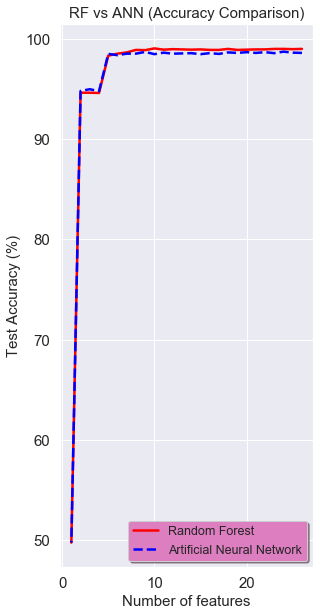

In [67]:
# Create plots with pre-defined labels
f = plt.figure(figsize = (10, 10))
ax = f.add_subplot(121)
t = list(np.arange(1., 27., 1))
t.reverse()
ax.plot(t, rf_acc, 'r-', label = 'Random Forest')
ax.plot(t, ann_acc, 'b--', label = 'Artificial Neural Network')

legend = ax.legend(loc = 'lower right', shadow = True, fontsize = 'x-small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C6')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Number of features')
plt.title('RF vs ANN (Accuracy Comparison)')
plt.show()

In [68]:
# Fitting Naive Bayes to the Training set
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [69]:
# Predicting the Test set results
y_pred = nb.predict(x_test)

Confusion matrix, without normalization
[[1954   35]
 [ 897 1114]]


<Figure size 432x288 with 0 Axes>

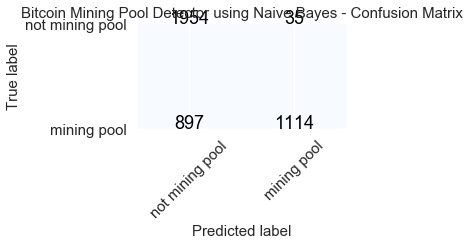

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['not mining pool', 'mining pool']
np.set_printoptions(precision = 3)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Bitcoin Mining Pool Detector using Naive Bayes - Confusion Matrix')

plt.show()

In [71]:
# Calculating Accuracy
acc = (cnf_matrix[0][0] + cnf_matrix[1][1]) / (cnf_matrix[0][0] + cnf_matrix[1][1] + cnf_matrix[0][1] + cnf_matrix[1][0])
print("Test Accuracy (Naive Bayes Classification): {}%" .format(acc * 100))

Test Accuracy (Naive Bayes Classification): 76.7%
